In [223]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFTGate  
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library.basis_change import QFT
from neqr import neqr
from ladder import ladder_up
from enhanced_grover import filter_oracle
from qsubtract import subtract
from qadd import qft_adder
from PIL import Image


In [224]:
num_bits = 4
intensity_bits =  3


In [225]:
image = np.array([
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0],
    [0,1,1,1,0,0,0,0],
    [0,1,1,1,0,0,0,0],
    [0,1,1,1,0,0,0,0],
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0]

])

In [226]:
def load_image(filepath, size=(16, 16)):
    img = Image.open(filepath).convert('L')  # Grayscale
    img = img.resize(size, Image.Resampling.LANCZOS)
    img_array = np.array(img)
    return img_array

def normalize_image(image, bits=3):
    max_val = 2**bits - 1
    return np.round((image / 255) * max_val).astype(int)

image = load_image('heartimg.png',size=(16,16))
image = normalize_image(image, bits=3)
print(image)

[[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 6 7 7 7 7 7 7 7 6 7 7 7]
 [7 6 1 0 1 1 6 7 7 6 1 1 1 1 7 7]
 [6 1 2 2 2 1 1 6 6 1 2 2 2 1 2 7]
 [0 2 7 6 2 2 2 1 1 2 2 2 2 2 1 1]
 [0 2 6 2 2 2 2 2 2 2 2 2 2 2 1 1]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0]
 [1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2]
 [7 2 1 2 2 2 2 2 2 2 2 2 2 1 2 7]
 [7 7 2 1 2 2 2 2 2 2 2 2 1 2 7 7]
 [7 7 7 2 1 2 2 2 2 2 2 1 2 7 7 7]
 [7 7 7 7 2 1 2 2 2 2 1 2 7 7 7 7]
 [7 7 7 7 7 2 1 2 2 1 3 7 7 7 7 7]
 [7 7 7 7 7 7 2 1 1 3 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 2 3 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]]


In [227]:
x = QuantumRegister(num_bits, name='x')
y = QuantumRegister(num_bits, name='y')
i1 = QuantumRegister(intensity_bits, name='I₁')
i2 = QuantumRegister(intensity_bits, name='I₂')
grad1 = QuantumRegister(intensity_bits, name='Grad1')
oracle_a = QuantumRegister(1, name = 'oracle_a')
grad2c = QuantumRegister(1, name='Grad2c')
anc = QuantumRegister(1, name='a')
anc2 = QuantumRegister(1, name = 'a2')
cr = ClassicalRegister(num_bits*2 + 1, name='c')

In [228]:
qc = QuantumCircuit(x, y, i1, i2, grad1, grad2c, anc, anc2, oracle_a, cr)


In [229]:
qc.h(x)
qc.h(y)
qc.barrier()


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=21, num_clbits=0, params=[]), qubits=(<Qubit register=(4, "x"), index=0>, <Qubit register=(4, "x"), index=1>, <Qubit register=(4, "x"), index=2>, <Qubit register=(4, "x"), index=3>, <Qubit register=(4, "y"), index=0>, <Qubit register=(4, "y"), index=1>, <Qubit register=(4, "y"), index=2>, <Qubit register=(4, "y"), index=3>, <Qubit register=(3, "I₁"), index=0>, <Qubit register=(3, "I₁"), index=1>, <Qubit register=(3, "I₁"), index=2>, <Qubit register=(3, "I₂"), index=0>, <Qubit register=(3, "I₂"), index=1>, <Qubit register=(3, "I₂"), index=2>, <Qubit register=(3, "Grad1"), index=0>, <Qubit register=(3, "Grad1"), index=1>, <Qubit register=(3, "Grad1"), index=2>, <Qubit register=(1, "Grad2c"), index=0>, <Qubit register=(1, "a"), index=0>, <Qubit register=(1, "a2"), index=0>, <Qubit register=(1, "oracle_a"), index=0>), clbits=())

In [230]:
neqr_gate1 = neqr(i1,x,y,image)
qc.append(neqr_gate1, list(i1) + list(x) + list(y))


In [231]:
# Shift up: ladder_up
ladder = ladder_up(x)
qc.append(ladder, list(x))

In [232]:
qc.append(neqr_gate1, list(i2) + list(x) + list(y))
ladder_down = ladder.inverse()


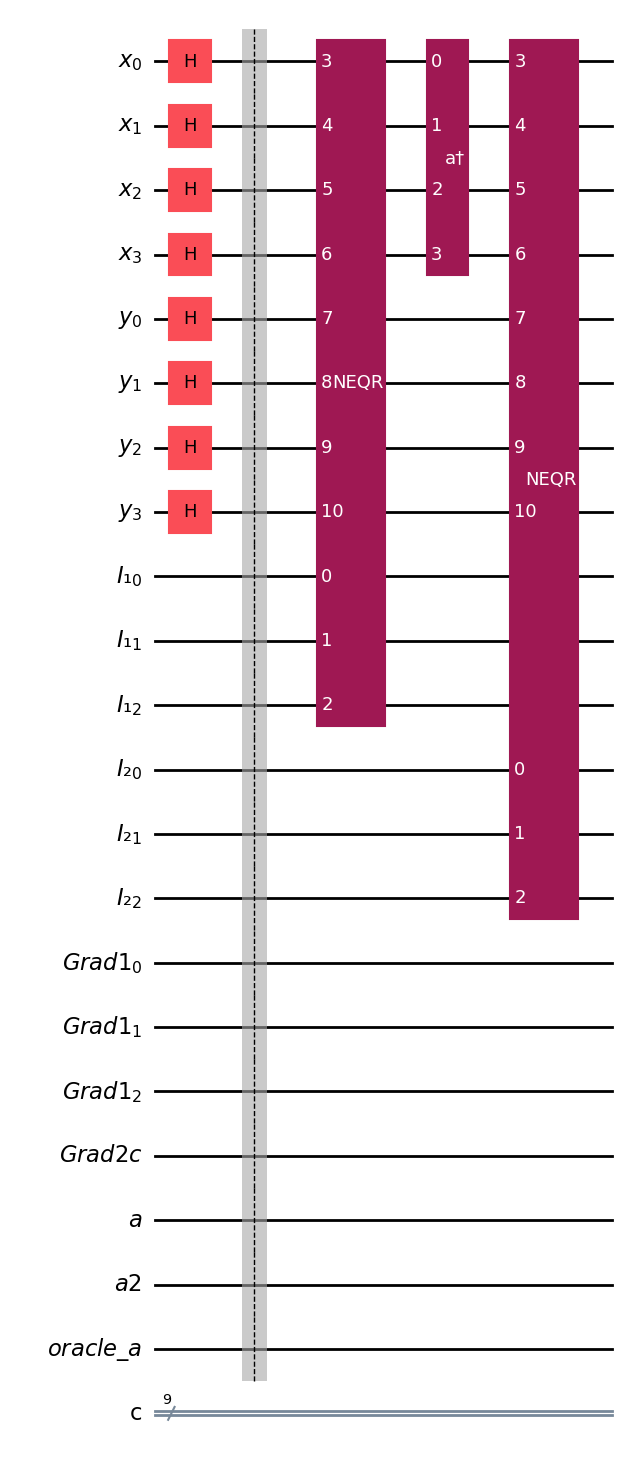

In [233]:
qc.draw('mpl')

In [234]:
#qc.measure(list(x) + list(y) + list(i1) + list(i2), list(cr))

In [235]:
for i in range(intensity_bits):
    qc.cx(i2[i], grad1[i])

In [236]:
sub1 = subtract(i1, grad1, anc)
qc.append(sub1, list(i1) + list(grad1) + list(anc))

In [237]:
neqr1_inverse = neqr_gate1.inverse()
qc.append(neqr1_inverse, list(i2) + list(x) + list(y))

In [238]:
ladder_down = ladder.inverse()
qc.append(ladder_down,list(x))
qc.append(ladder, list(y))

In [239]:
qc.append(neqr_gate1, list(i2) + list(x) + list(y))

In [240]:
qc.append(ladder_down,list(y))

In [241]:
qc.append(sub1, list(i1) + list(i2) + list(anc2))


In [242]:
add = qft_adder(grad1,grad2,grad2c)
qc.append(add, list(grad1) + list(i2) + list(grad2c))

In [243]:
qc.barrier()
qc.h(oracle_a)

og = filter_oracle("0001")
cog = og.control(1,label="Og")
qc.append(cog, list(oracle_a) + list(i2) + list(grad2c))

qc.h(oracle_a)
qc.barrier()

4
[1, 0, 0, 0]
3 0
max 3
2 0
1 0
0 1


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=21, num_clbits=0, params=[]), qubits=(<Qubit register=(4, "x"), index=0>, <Qubit register=(4, "x"), index=1>, <Qubit register=(4, "x"), index=2>, <Qubit register=(4, "x"), index=3>, <Qubit register=(4, "y"), index=0>, <Qubit register=(4, "y"), index=1>, <Qubit register=(4, "y"), index=2>, <Qubit register=(4, "y"), index=3>, <Qubit register=(3, "I₁"), index=0>, <Qubit register=(3, "I₁"), index=1>, <Qubit register=(3, "I₁"), index=2>, <Qubit register=(3, "I₂"), index=0>, <Qubit register=(3, "I₂"), index=1>, <Qubit register=(3, "I₂"), index=2>, <Qubit register=(3, "Grad1"), index=0>, <Qubit register=(3, "Grad1"), index=1>, <Qubit register=(3, "Grad1"), index=2>, <Qubit register=(1, "Grad2c"), index=0>, <Qubit register=(1, "a"), index=0>, <Qubit register=(1, "a2"), index=0>, <Qubit register=(1, "oracle_a"), index=0>), clbits=())

In [244]:
qc.measure(list(x) + list(y) + list(oracle_a), list(cr))

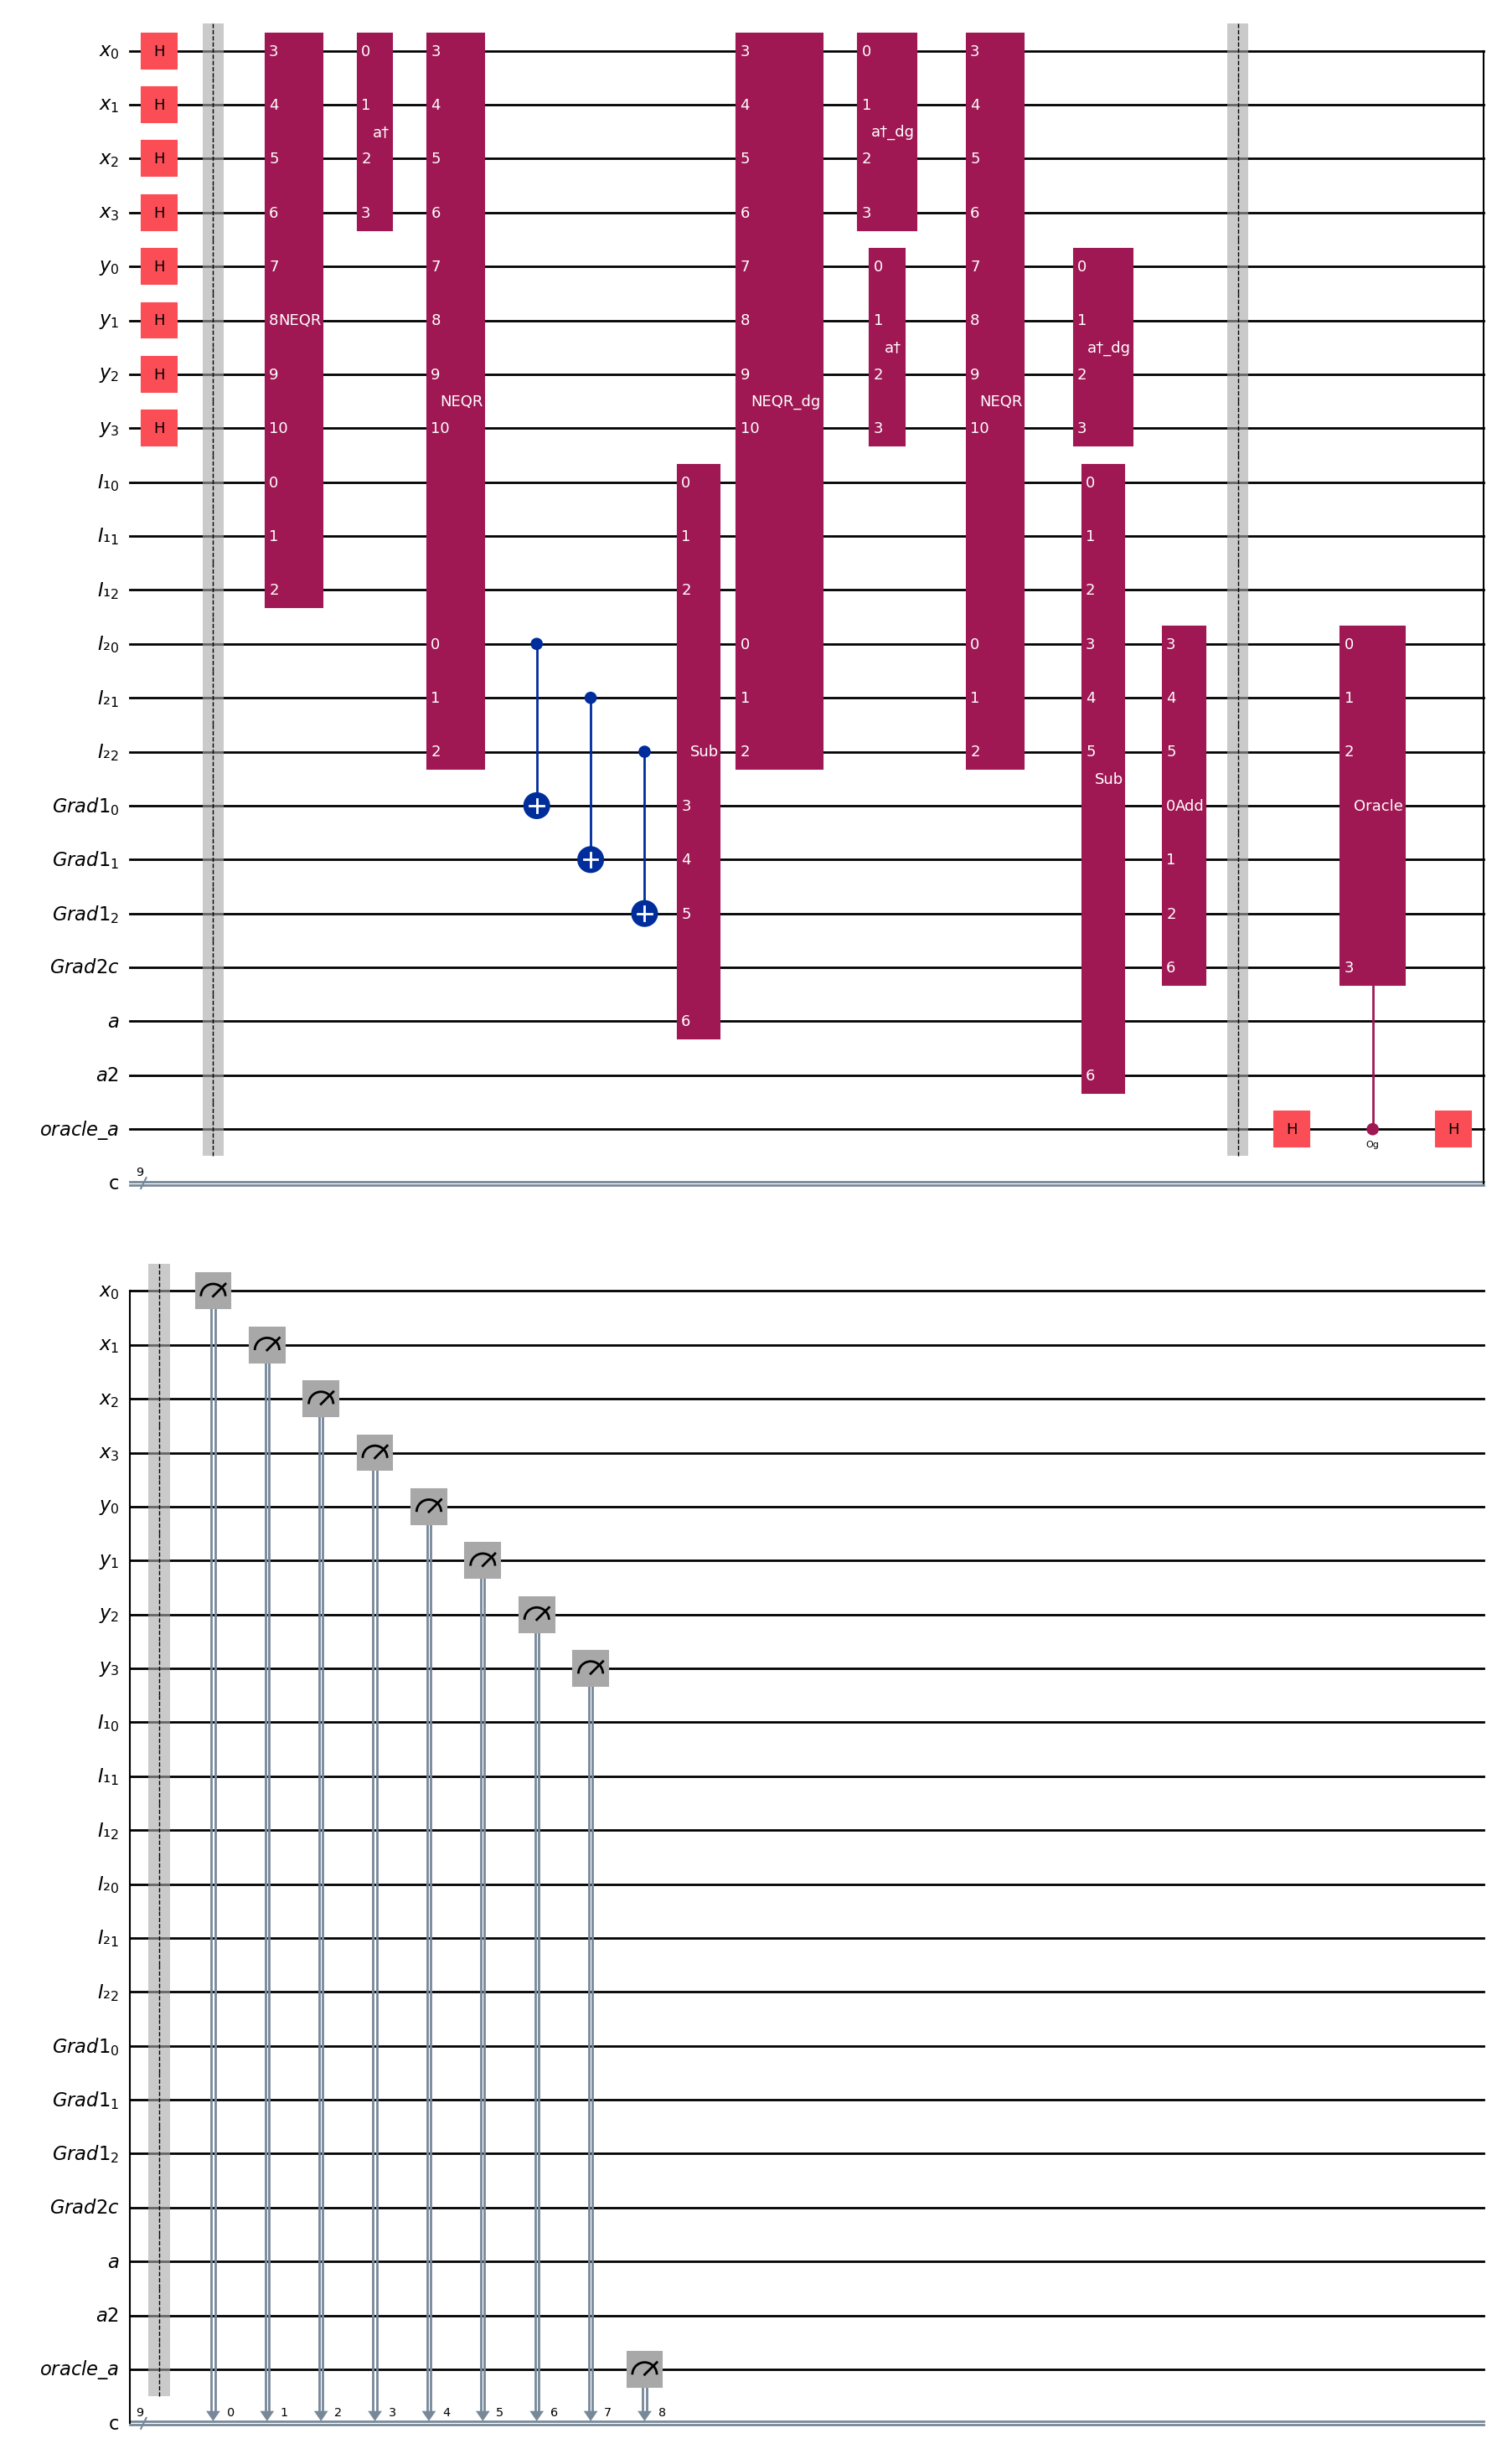

In [245]:
qc.draw('mpl')

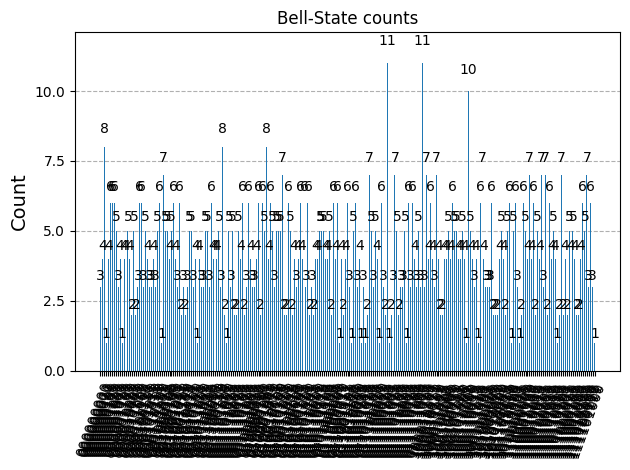

In [246]:
simulator = AerSimulator()
circ = transpile(qc, simulator)

result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

In [247]:
dim = 2**num_bits
edge_img = np.zeros((dim, dim), dtype=int)
for qstate, count in counts.items():

    intensity_bin = qstate[:1]
    y_bin = qstate[1:1 + num_bits]
    x_bin = qstate[1 + num_bits:1 + 2*num_bits]

    intensity = int(intensity_bin,2)  
    y = int(y_bin, 2)
    x = int(x_bin, 2)

    edge_img[y, x] = intensity
print(edge_img)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0]
 [1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0]
 [1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1]
 [1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0]
 [0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0]
 [0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0]
 [0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


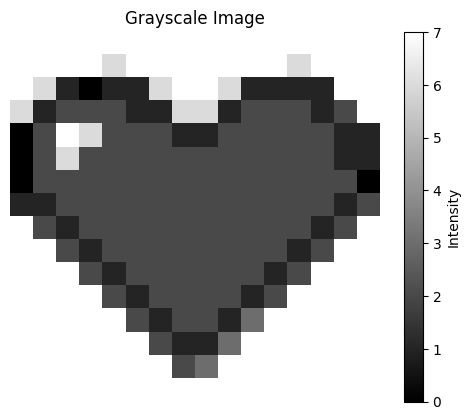

In [248]:
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Grayscale Image')
plt.axis('off')  # Hide axis ticks
plt.show()


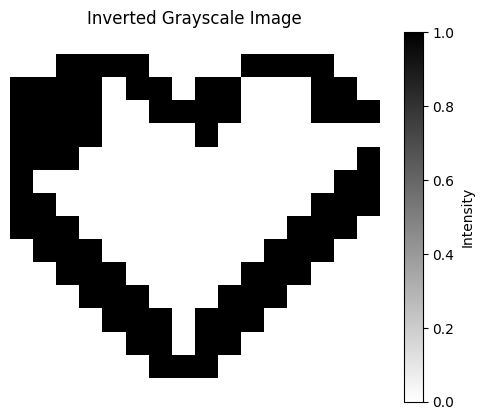

In [249]:
plt.imshow(edge_img, cmap='gray_r', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Inverted Grayscale Image')
plt.axis('off')
plt.show()